# <center> Simulator (custom)</center>

This code is used to create synthetic twitter datasets according to the model. We create a user graph and choose an activity pair $(\lambda,\mu)$ for each user . From there we can generate events of tweeting/retweeting where each user $i$ tweets with rate $\lambda_i$ and retweets from his newsfeed with rate $\mu_i$. The output consists of two `.txt` files, one being the adjacency list of the user graph and the other the list of tweets.

In [39]:
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
import matplotlib.pyplot as plt

Choose out folder where the results will be written.

In [40]:
out_folder = "../Datasets/Newman/rapportStage/"

## Setting parameters
Choose the number of users $N$, the number of events `nb_events` and the activity rates. The latter are in the form of two lists of length $N$: `Lambda` and `Mu` where `Lambda[i]` is the posting rate of user $i$ and `Mu[i]` is her reposting rate.

In [72]:
N = 100
w = 0.05
nb_events = 10000
# nb_events = 40*w*N*(N-1)

# Lambda = np.random.normal(10, 2, N)
# Lambda -= np.min(Lambda)
# Mu = np.random.normal(10, 2, N)
# Mu -= np.min(Mu)

Lambda = np.random.pareto(1.3, N)
Mu = np.random.pareto(1.3, N)

# Lambda = [0.1 for n in range(N)]
# Mu = [0.1 for n in range(N)]

# Lambda = np.random.random(N)
# Mu = np.random.random(N)

## 1. User graph creation

We represent the user graph with a dictionary `Followers` where `Followers[i]` is the set of leaders of user $i$.

In [56]:
# example: graph Erdös-Rényi of parameter w
Followers = {i:set() for i in range(N)}
for i in range(N):
    for j in range(N):
        if j != i and np.random.random() < w:
            Followers[i].add(j)
print("Number of edges: ", sum([len(Followers[i]) for i in range(N)]))

Number of edges:  470


Power-law graph.

In [73]:
# parameter (nb edges per new node)
m = 5

# dicts
Followers = {i:set() for i in range(N)}
deg = {i:0 for i in range(N)}

# first edges
Followers[0] = {1,2}
Followers[1] = {3}
Followers[3] = {0,4}
deg[0], deg[1], deg[2], deg[3], deg[4] = 2, 2, 1, 2, 1

# preferential attachment
for n in range(5,N):
    probs = np.array([deg[k] for k in range(n)])
    probs = probs / np.sum(probs)
    leaders = np.random.choice(range(n), size=m, replace=False, p=probs)
    for l in leaders:
        Followers[l].add(n)
        deg[l] += 1
    deg[n] += m
print("Number of edges: ", sum([len(Followers[i]) for i in range(N)]))

Number of edges:  480


Check connectedness of graph.

In [74]:
G = nx.DiGraph()
for lead in Followers:
    for follow in Followers[lead]:
        G.add_edge(lead,follow)
print(nx.is_strongly_connected(G), nx.is_weakly_connected(G))

False True


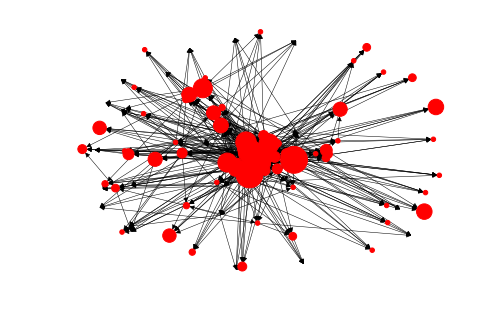

In [75]:
nx.draw(G, node_size=[20*len(Followers[n]) for n in range(N)], width=.5)
plt.savefig(out_folder + "graph_power.pdf")

Write adjacency list on file.

In [76]:
graph_out = open(out_folder + "adjList_power.txt", "w")
for i in Followers:
    for j in Followers[i]:
        graph_out.write("{} {}\n".format(i,j))
graph_out.close()

## 2. Events creation

We generate a list `events` where the $i^{th}$ entry corresponds to the $i^{th}$ event occurring on the network. Each event is described as a tuple `twid timestamp userid rtid`, with
- `twid` is the unique id of the tweet, $\in \{1, \ldots, nb\_events\}$
- `timestamp` is the instant of occurence (seconds since the beginning)
- `userid` is the unique id $\in \{1, \ldots, N\}$ of the (re)tweeting user
- `rtid` is the id of the original tweet in case of retweet, else is set to -1.

In [77]:
news = {i:list() for i in range(N)} # initialization of the newsfeeds
M = 1 # newsfeeds max size
next_twid = 1 # id of the next post
time = 0 # time since the beginning
Events = list() # list of events (output)

while len(Events) < nb_events:
    
    # generate exponential variates of scale 1/lambda, 1/mu for each user
    waiting_time = set()
    for n in range(N):
        if Lambda[n] > 0:
            waiting_time.add((n, 'post', np.random.exponential(1/Lambda[n])))
        if Mu[n] > 0:
            waiting_time.add((n, 'repost', np.random.exponential(1/Mu[n])))

    # next_event
    user, event_type, wait = min(waiting_time, key=itemgetter(2))
    time += wait
    if event_type == 'post':
        new_post = (next_twid, time, user, -1) # create new post
    else:
        if len(news[user]) == 0: # skip step if nothing to repost in the user's newsfeed
            continue
        else:
            retweeted = random.choice(news[user]) # choose what to retweet
            if retweeted[-1] == -1: # get original id
                rtid = retweeted[0]
            else:
                rtid = retweeted[-1]
            new_post = (next_twid, time, user, rtid) # create new_post
            
            
    # append new post to the events list and update next_twid
    Events.append(new_post)
    next_twid += 1

    # update newfeeds for followers of active user
    for j in Followers[user]:
        if len(news[j]) == M: # remove something at random if newsfeed is full
            news[j].remove(random.choice(news[j]))
        news[j].append(new_post) # add new post to newsfeed

Look at first events.

In [79]:
Events[:10]

[(1, 0.003986432611542437, 53, -1),
 (2, 0.005100893956052431, 90, -1),
 (3, 0.005335029416615595, 29, -1),
 (4, 0.005341821320847165, 77, -1),
 (5, 0.014764530559469864, 88, -1),
 (6, 0.015418964960760196, 29, -1),
 (7, 0.029601926935202968, 2, -1),
 (8, 0.03220809428582751, 53, -1),
 (9, 0.046852475647382624, 66, -1),
 (10, 0.049495163073036086, 30, -1)]

Write events list to `outfolder/trace.txt`. Each line is an entry of the list.

In [80]:
out = open(out_folder + "trace_power.txt", "w")
for e in Events:
    out.write("{} {} {} {}\n".format(e[0], e[1], e[2], e[3]))
out.close()

In [ ]:
len(Followers[0])

Old algo.

In [ ]:
news = {i:list() for i in range(N)} # initialization of the newsfeeds
M = 1 # newsfeeds max size
next_twid = 1 # id of the next post
time = 0 # time since the beginning
Events = list() # list of events (output)

while len(Events) < nb_events:
    
    posting_time = np.random.exponential([1/x for x in Lambda], N)
    reposting_time = np.random.exponential([1/x for x in Mu], N)
    
    # get closest posting time and reposting time ---> next event will be the closest between both
    min_post = np.min(posting_time)
    min_repost = np.min(reposting_time)
    
    # if the next event is a post
    if min_post < min_repost:
        time += min_post
        user = np.argmin(posting_time)
        new_post = (next_twid, time, user, -1) # create new post
    
    # if repost
    elif min_repost < min_post:
        time += min_repost
        user = np.argmin(reposting_time)
        if len(news[user]) == 0: # skip step if nothing to repost in the user's newsfeed
            continue
        else:
            retweeted = random.choice(news[user]) # choose what to retweet
            if retweeted[-1] == -1: # get original id
                rtid = retweeted[0]
            else:
                rtid = retweeted[-1]
            new_post = (next_twid, time, user, rtid) # create new_post
            
            
    # append new post to the events list and update next_twid
    Events.append(new_post)
    next_twid += 1

    # update newfeeds for followers of active user
    for j in Followers[user]:
        if len(news[j]) == M: # remove something at random if newsfeed is full
            news[j].remove(random.choice(news[j]))
        news[j].append(new_post) # add new post to newsfeed